In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Big Data/PJ_BigData')

#Thiết lập pyspark

In [10]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [11]:
!wget -q https://dlcdn.apache.org/spark/spark-3.5.2/spark-3.5.2-bin-hadoop3.tgz

In [12]:
!tar xf spark-3.5.2-bin-hadoop3.tgz

In [13]:
#thiết lập đường dẫn môi trường
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/MyDrive/Big Data/PJ_BigData/spark-3.5.2-bin-hadoop3"

In [3]:
!pip install -q findspark

In [6]:
import findspark
findspark.init()

In [14]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Cluster Weather ")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [15]:
!pip install pyngrok

Ấn vào link "https://faa2-34-86-210-137.ngrok-free.app"


In [69]:
!ngrok authtoken 2kuRLUhjQncBY0dssyYcOUr0NKQ_4mjFw1sKDiKiCkKnT3RTW  # Xác thực token
from pyngrok import ngrok
public_url = ngrok.connect(addr='4050', proto='http')
print(public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
NgrokTunnel: "https://bf84-104-199-173-206.ngrok-free.app" -> "http://localhost:4050"


#Đọc dữ liệu

In [17]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, isnan, when, count, udf, year, month, to_date, mean
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
data = spark.read \
    .option("header", False) \
    .option("sep", ",") \
    .option("inferSchema", True) \
    .csv(path=f'/content/drive/MyDrive/Big Data/PJ_BigData/Data/zurich-weather-part-a.csv')



In [19]:
data.show(5)
print('----------------------------------------------------')
data.printSchema()
print('----------------------------------------------------')
data.describe().show()

+---+----------+-----+---+-----+----+----+----+----+----+
|_c0|       _c1|  _c2|_c3|  _c4| _c5| _c6| _c7| _c8| _c9|
+---+----------+-----+---+-----+----+----+----+----+----+
|  0|1979-01-01| -5.3|1.0|  0.0|NULL|NULL|NULL|NULL|NULL|
|  1|1979-01-02|-10.0|1.7| 10.0|NULL|NULL|NULL|NULL|NULL|
|  2|1979-01-03| -5.8|0.0|110.0|NULL|NULL|NULL|NULL|NULL|
|  3|1979-01-04| -8.4|0.0|100.0|NULL|NULL|NULL|NULL|NULL|
|  4|1979-01-05|-10.0|0.0| 70.0|NULL|NULL|NULL|NULL|NULL|
+---+----------+-----+---+-----+----+----+----+----+----+
only showing top 5 rows

----------------------------------------------------
root
 |-- _c0: integer (nullable = true)
 |-- _c1: date (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: string (nullable = true)

---------------------------------------------

In [20]:
data2 = spark.read \
    .option("header", False) \
    .option("sep", ",") \
    .option("inferSchema", True) \
    .csv(path=f'/content/drive/MyDrive/Big Data/PJ_BigData/Data/zurich-weather-part-b.csv')



In [21]:
data2.show(5)
print('----------------------------------------------------')
data2.printSchema()
print('----------------------------------------------------')
data2.describe().show()

+---+----------+----+-----+
|_c0|       _c1| _c2|  _c3|
+---+----------+----+-----+
|  0|1979-01-01|-2.5|-12.2|
|  1|1979-01-02|-4.2|-12.2|
|  2|1979-01-03|-3.9| -7.9|
|  3|1979-01-04|-4.4|-10.5|
|  4|1979-01-05|-7.5|-11.2|
+---+----------+----+-----+
only showing top 5 rows

----------------------------------------------------
root
 |-- _c0: integer (nullable = true)
 |-- _c1: date (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)

----------------------------------------------------
+-------+------------------+------------------+-----------------+
|summary|               _c0|               _c2|              _c3|
+-------+------------------+------------------+-----------------+
|  count|             15383|             15374|            15368|
|   mean|182.63121627770917|13.705762976453707|6.066957313898991|
| stddev|105.73420482794725| 8.830919147315488|6.620985806040896|
|    min|                 0|             -15.2|            -20.8|
|    max| 

#Nối 2 bảng dữ liệu

Đầu tiên,em sẽ nối hai tập dữ liệu bằng hàm Join

Xóa một số cột không liên quan

Đổi lại tên từng cột

Chọn và đổi tên các cột bằng cách sử dụng Select() với Alias()

In [22]:
#xóa cột không cần thiết
data = data.drop("_c0")
data2 = data2.drop("_c0")

In [23]:
#đổi tên các cột
data2_rm = data2.withColumnRenamed("_c1", "date") \
    .withColumnRenamed("_c2", "max_temp") \
    .withColumnRenamed("_c3", "min_temp")
#hàm đổi tên các cột
def rename_multiple_columns(df, columns):
    if isinstance(columns, dict):
        for old_name, new_name in columns.items():
            df = df.withColumnRenamed(old_name, new_name)
        return df

ten_cot       = {"_c1": "date2",
                "_c2": "avg_temp",
                "_c3": "precip",
                "_c4": "snow",
                "_c5": "wind_dir",
                "_c6": "wind_speed",
                "_c7": "wind_power",
                "_c8": "air_pressure",
                "_c9": "sunny_hours",}
data_rm = rename_multiple_columns(data , ten_cot)

# Nối 2 bảng
data_join = data_rm.join(data2_rm, data_rm.date2 == data2_rm.date, "inner")

In [24]:
data_join.show(5)

+----------+--------+------+-----+--------+----------+----------+------------+-----------+----------+--------+--------+
|     date2|avg_temp|precip| snow|wind_dir|wind_speed|wind_power|air_pressure|sunny_hours|      date|max_temp|min_temp|
+----------+--------+------+-----+--------+----------+----------+------------+-----------+----------+--------+--------+
|1979-01-01|    -5.3|   1.0|  0.0|    NULL|      NULL|      NULL|        NULL|       NULL|1979-01-01|    -2.5|   -12.2|
|1979-01-02|   -10.0|   1.7| 10.0|    NULL|      NULL|      NULL|        NULL|       NULL|1979-01-02|    -4.2|   -12.2|
|1979-01-03|    -5.8|   0.0|110.0|    NULL|      NULL|      NULL|        NULL|       NULL|1979-01-03|    -3.9|    -7.9|
|1979-01-04|    -8.4|   0.0|100.0|    NULL|      NULL|      NULL|        NULL|       NULL|1979-01-04|    -4.4|   -10.5|
|1979-01-05|   -10.0|   0.0| 70.0|    NULL|      NULL|      NULL|        NULL|       NULL|1979-01-05|    -7.5|   -11.2|
+----------+--------+------+-----+------

In [25]:
#xóa cột date và sunny_hours
data_join = data_join.drop("date")
data_join = data_join.drop("sunny_hours")

#Tìm hiểu và xử lý dữ liệu

In [27]:
#tính giá trị null
data_join.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c, y in data_join.dtypes if y in ["double", "float"]]).toPandas()

,avg_temp,precip,snow,wind_dir,wind_speed,wind_power,air_pressure,max_temp,min_temp
0,21,0,143,14577,14565,14565,14565,9,15


In [28]:
#Kiểm tra trùng lặp
dups = data_join.groupby('date2') \
    .count() \
    .filter(F.col('count') > 1) \
    .limit(10) \
    .toPandas()
print(dups)

        date2  count
0  1982-01-01      4
1  2009-01-01      4
2  2016-01-01      4
3  1998-01-01      4
4  2008-01-01      4
5  2011-01-01      4
6  1981-01-01      4
7  2017-01-01      4
8  2007-01-01      4
9  1997-01-01      4


In [29]:
#Xử lý giá trị null bằng cách thay thế giá trị mean
avg = data_join.filter(data_join.avg_temp.isNotNull())\
    .select(mean(col('min_temp')).alias('mean_min'),
            mean(col('max_temp')).alias('mean_max'),
            mean(col('wind_speed')).alias('mean_wind'),
            mean(col('avg_temp')).alias('mean_avg'),
            mean(col('wind_dir')).alias('mean_dir'),
            mean(col('wind_power')).alias('mean_power'),
            mean(col('air_pressure')).alias('mean_pressure'),
            ).collect()

mean_min = avg[0]['mean_min']
mean_max = avg[0]['mean_max']
mean_wind = avg[0]['mean_wind']
mean_avg = avg[0]['mean_avg']
mean_dir = avg[0]['mean_dir']
mean_power = avg[0]['mean_power']
mean_pressure = avg[0]['mean_pressure']

# Thay thế giá trị null
data_join = data_join \
    .na.fill(value=mean_min, subset=["min_temp"]) \
    .na.fill(value=mean_max, subset=["max_temp"]) \
    .na.fill(value=mean_wind, subset=["wind_speed"]) \
    .na.fill(value=0, subset=["snow"]) \
    .na.fill(value=mean_avg, subset=["avg_temp"]) \
    .na.fill(value=mean_dir, subset=["wind_dir"]) \
    .na.fill(value=mean_power, subset=["wind_power"]) \
    .na.fill(value=mean_pressure, subset=["air_pressure"])

In [30]:
data_join.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c, y in data_join.dtypes if y in ["double", "float"]]).toPandas()

,avg_temp,precip,snow,wind_dir,wind_speed,wind_power,air_pressure,max_temp,min_temp
0,0,0,0,0,0,0,0,0,0


In [31]:
#xóa các giá trị trùng lặp
data_join = data_join.dropDuplicates()
#kiểm tra còn trùng lặp không
dups = data_join.groupby('date2') \
    .count() \
    .filter(F.col('count') > 1) \
    .limit(10) \
    .toPandas()
print(dups)

Empty DataFrame
Columns: [date2, count]
Index: []


In [71]:
data_join.show(5)

+----------+--------+------+----+------------------+-----------------+-----------------+------------------+--------+--------+
|     date2|avg_temp|precip|snow|          wind_dir|       wind_speed|       wind_power|      air_pressure|max_temp|min_temp|
+----------+--------+------+----+------------------+-----------------+-----------------+------------------+--------+--------+
|1979-05-02|     4.0|  17.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|     5.5|     0.5|
|1979-07-25|    18.0|   0.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|    24.4|    11.1|
|1980-03-03|     1.5|   0.1| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|     4.1|     0.3|
|1980-04-29|     8.4|   0.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|    14.8|     2.0|
|1980-10-21|     4.2|   0.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|     9.8|  

#Trực quan hóa dữ liệu

<Axes: xlabel='year', ylabel='month'>

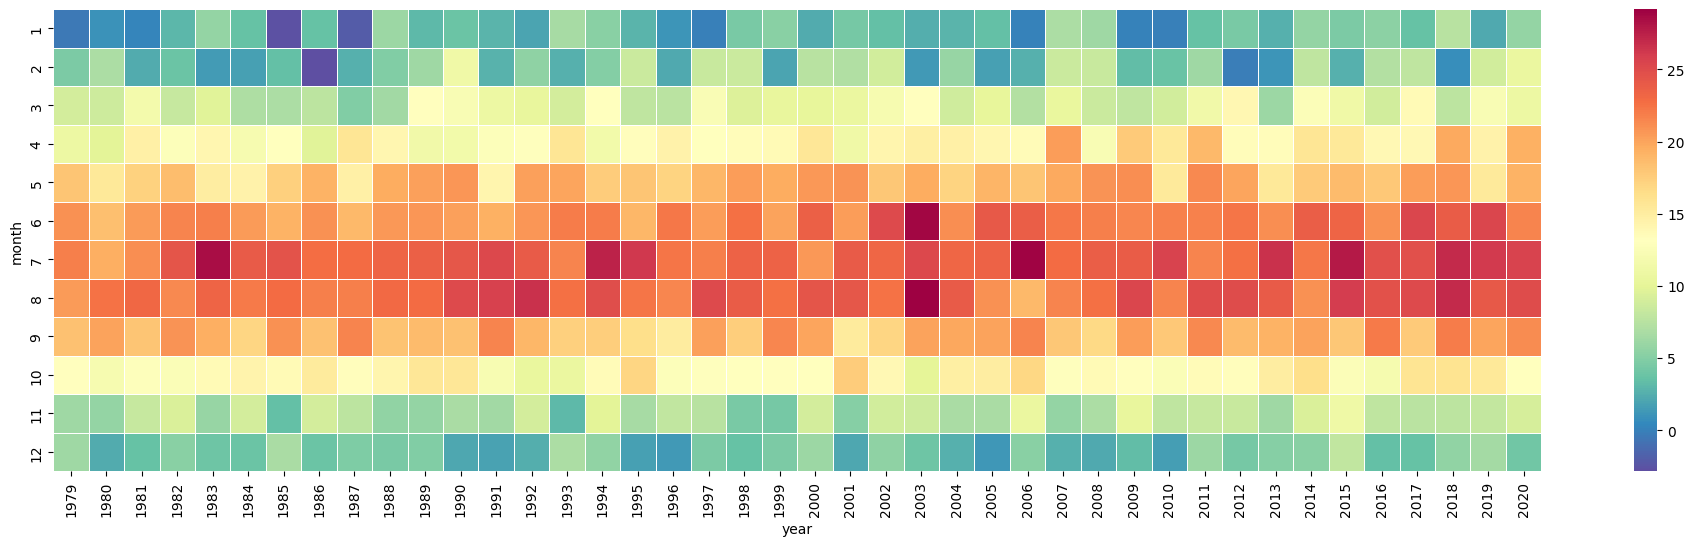

In [ ]:
from pyspark.sql.functions import year, month, mean, col

spark_cleaned_df_agg = data_join.select(year(col("date2")).alias("year"),
                                       month(col("date2")).alias("month"),
                                       col("max_temp")) \
    .filter(year(col("date2")) < 2021)\
    .groupby(col("year"),col("month"))\
    .agg(mean("max_temp").alias("mean_max_temp")) \
    .orderBy(col("year")).toPandas()

plt.figure(figsize=(24,6))
# Use keyword arguments for index, columns, and values
avg_temp_df = spark_cleaned_df_agg.pivot(index="month", columns="year", values="mean_max_temp")
sns.heatmap(avg_temp_df, cmap="Spectral_r", linewidths=.5)

Text(0.5, 1.0, 'Nhiệt độ min - max phân tách theo tháng')

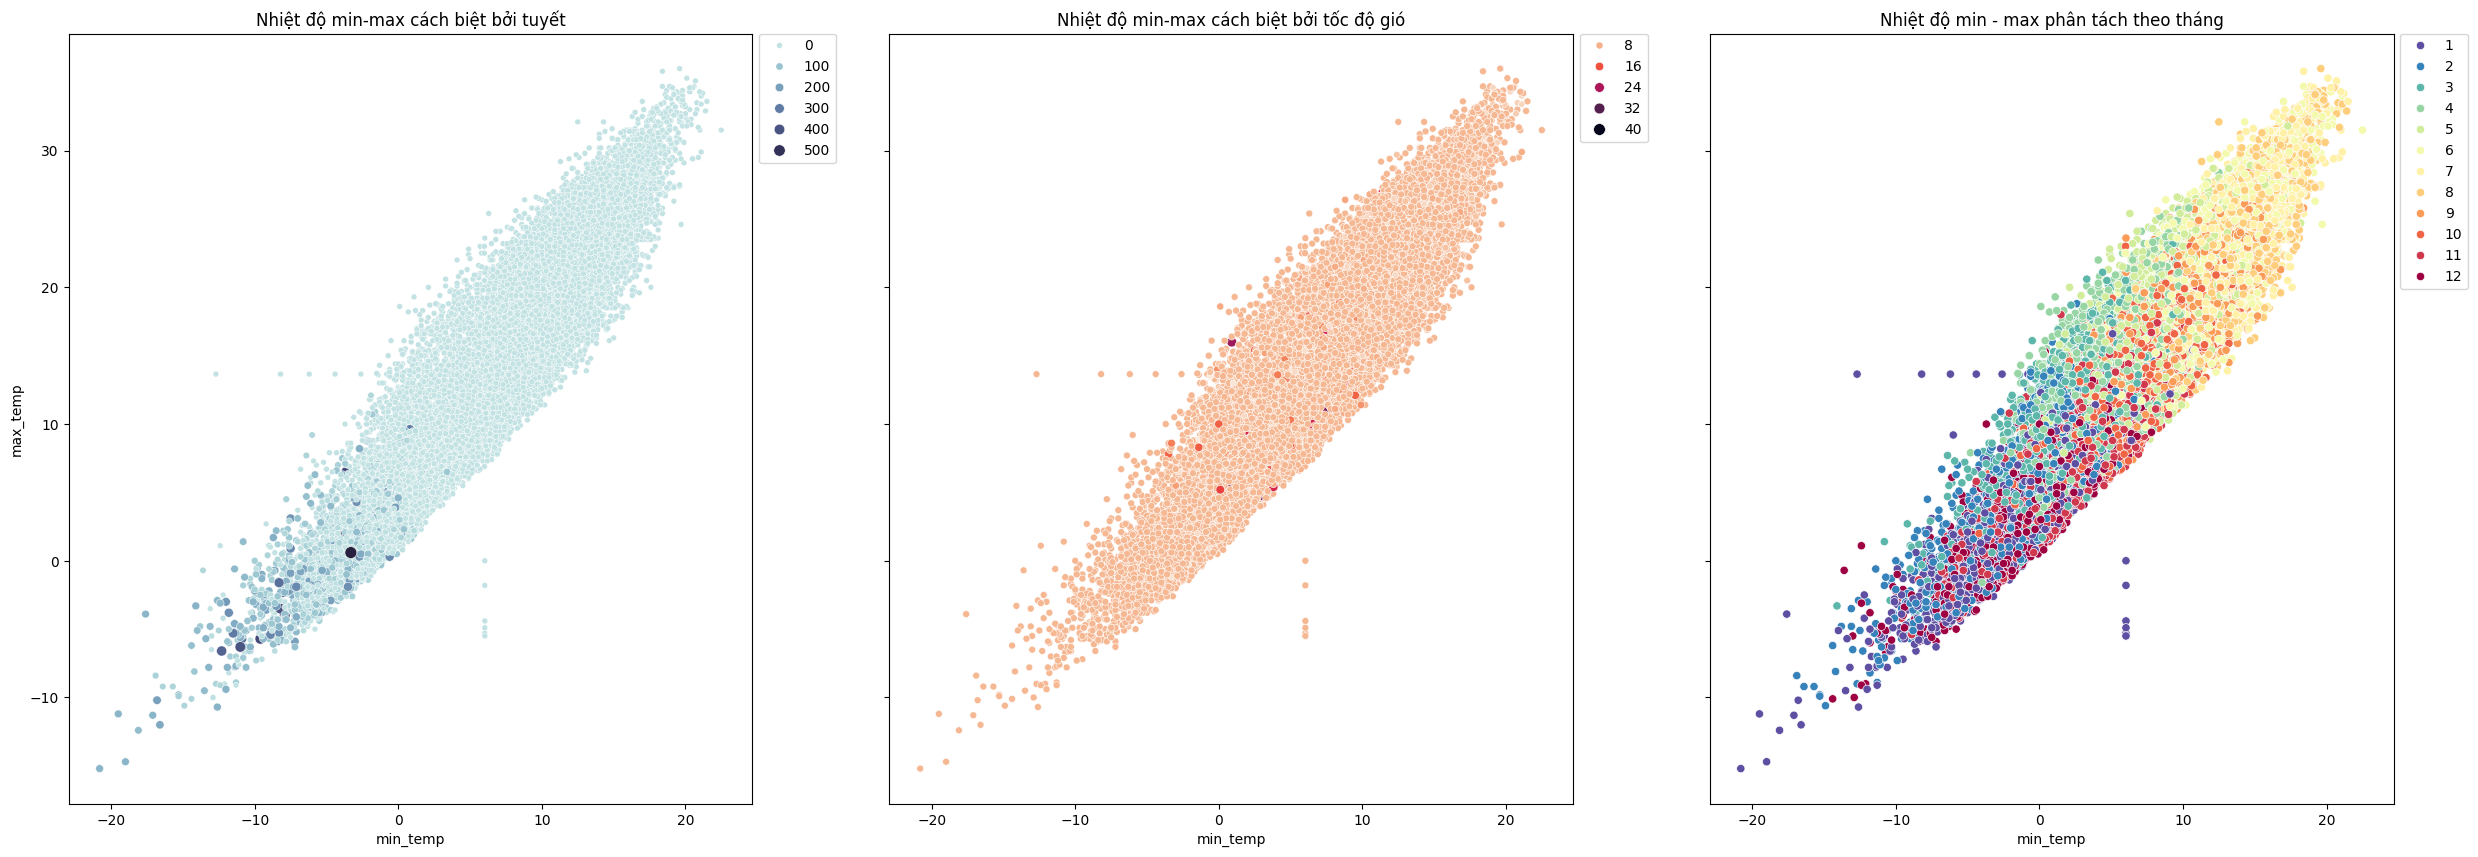

In [ ]:
# Thêm cột tháng vào Pandas DataFrame
data_join_pd = data_join.withColumn("month", month(col("date2"))).toPandas()

fig, axes= plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(30, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

palette = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.scatterplot(ax = axes[0], hue="snow", size="snow", y="max_temp", x="min_temp", data=data_join_pd, alpha=1.0, palette=palette)
axes[0].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[0].set_title("Nhiệt độ min-max cách biệt bởi tuyết")

sns.scatterplot(ax = axes[1], hue="wind_speed", size="wind_speed", y="max_temp", x="min_temp", data=data_join_pd, alpha=1.0, palette='rocket_r')
axes[1].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[1].set_title("Nhiệt độ min-max cách biệt bởi tốc độ gió")

sns.scatterplot(ax = axes[2], hue="month", y="max_temp", x="min_temp", data=data_join_pd, alpha=1.0, palette='Spectral_r', hue_norm=(1,12), legend="full")
axes[2].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[2].set_title("Nhiệt độ min - max phân tách theo tháng")

#Phân cụm

In [32]:
data_clus = data_join.drop("date2")

In [33]:
data_clus.show(5)

+--------+------+----+------------------+-----------------+-----------------+------------------+--------+--------+
|avg_temp|precip|snow|          wind_dir|       wind_speed|       wind_power|      air_pressure|max_temp|min_temp|
+--------+------+----+------------------+-----------------+-----------------+------------------+--------+--------+
|     4.0|  17.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|     5.5|     0.5|
|    18.0|   0.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|    24.4|    11.1|
|     1.5|   0.1| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|     4.1|     0.3|
|     8.4|   0.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|    14.8|     2.0|
|     4.2|   0.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|     9.8|     0.0|
+--------+------+----+------------------+-----------------+-----------------+---

In [34]:
from pyspark.ml.feature import VectorAssembler
feature_columns = data_clus.columns
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(data_clus)
df_assembled.show(5)

+--------+------+----+------------------+-----------------+-----------------+------------------+--------+--------+--------------------+
|avg_temp|precip|snow|          wind_dir|       wind_speed|       wind_power|      air_pressure|max_temp|min_temp|            features|
+--------+------+----+------------------+-----------------+-----------------+------------------+--------+--------+--------------------+
|     4.0|  17.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|     5.5|     0.5|[4.0,17.0,0.0,156...|
|    18.0|   0.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|    24.4|    11.1|[18.0,0.0,0.0,156...|
|     1.5|   0.1| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|     4.1|     0.3|[1.5,0.1,0.0,156....|
|     8.4|   0.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|    14.8|     2.0|[8.4,0.0,0.0,156....|
|     4.2|   0.0| 0.0|156.79842342342343|7.33033

* Để lựa chọn số lượng phân cụm phù hợp em sẽ thử sử dụng 2 phương pháp Elbow method và Silhouette score để chọn số cụm phù hợp

Phương pháp Elbow là một kỹ thuật trực quan để xác định số lượng cụm tốt nhất cho phân cụm KMeans. Phương pháp này dựa trên việc vẽ đồ thị của tổng khoảng cách bình phương từ các điểm dữ liệu đến tâm cụm của chúng (WSSSE - Within-Cluster Sum of Squared Errors) đối với nhiều giá trị k (số lượng cụm). Sau đó, bạn tìm "khuỷu tay" hoặc điểm gập trên đồ thị để xác định số lượng cụm tối ưu.

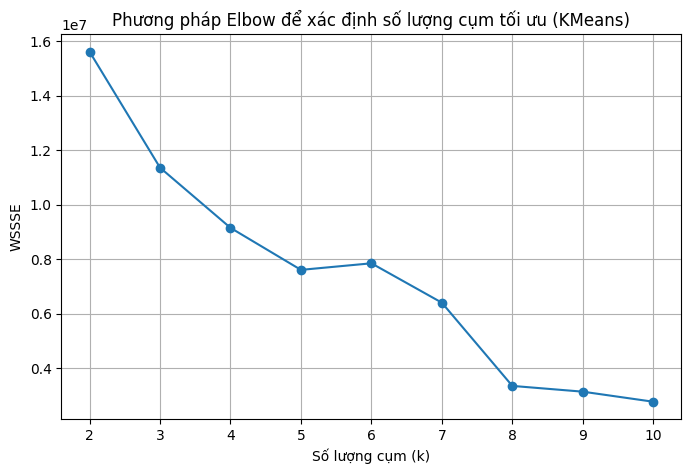

In [47]:
#KMeans_Elbow
from pyspark.ml.clustering import KMeans
wssse = []
for k in range(2, 11):
    KMeans_Elbow = KMeans(k=k, seed=1)
    KMeans_Elbow = KMeans_Elbow.fit(df_assembled)
    wssse.append(KMeans_Elbow.summary.trainingCost)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), wssse, marker='o')
plt.xlabel('Số lượng cụm (k)')
plt.ylabel('WSSSE')
plt.title('Phương pháp Elbow để xác định số lượng cụm tối ưu (KMeans)')
plt.grid(True)
plt.show()

Silhouette score (điểm Silhouette) là một chỉ số đo lường chất lượng của việc phân cụm dữ liệu trong các thuật toán clustering. Nó giúp đánh giá sự phù hợp của mỗi điểm dữ liệu với cụm mà nó thuộc về và cách mà điểm dữ liệu đó khác biệt với các cụm khác

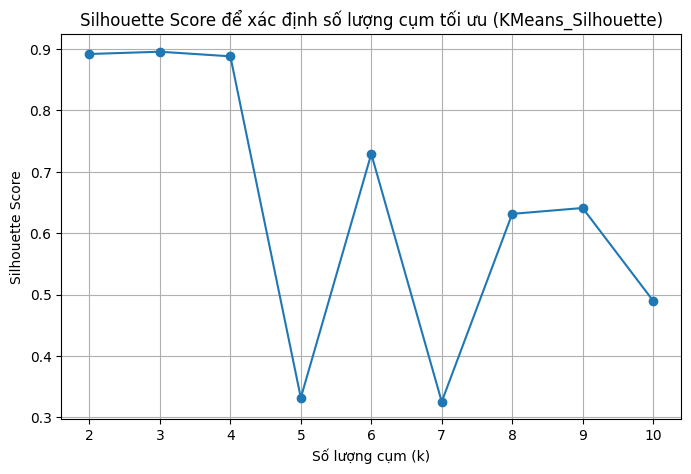

In [44]:
#KMeans_Silhouette
from pyspark.ml.evaluation import ClusteringEvaluator

# Tính toán Silhouette score cho nhiều giá trị k
silhouette_scores = []

for k in range(2, 11):
    KMeans_Silhouette = KMeans(k=k, seed=1)
    KMeans_Silhouette = KMeans_Silhouette.fit(df_assembled)
    predictions = KMeans_Silhouette.transform(df_assembled)

    evaluator = ClusteringEvaluator()
    silhouette_score = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette_score)

# Vẽ biểu đồ Silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2,11), silhouette_scores, marker='o')
plt.xlabel('Số lượng cụm (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score để xác định số lượng cụm tối ưu (KMeans_Silhouette)')
plt.grid(True)
plt.show()

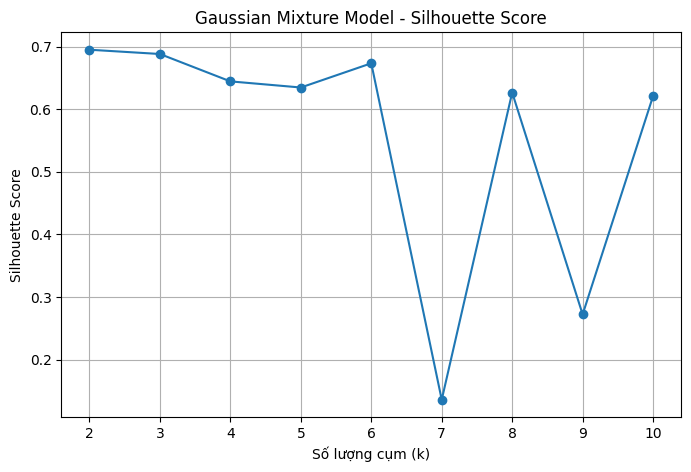

In [52]:
#GaussianMixture_Silhouette
import numpy as np
from sklearn.metrics import silhouette_score
from pyspark.ml.clustering import GaussianMixture

silhouette_scores = []

for k in range(2, 11):
    GaussianMixture_Silhouette = GaussianMixture(k=k, seed=1)
    GaussianMixture_Silhouette = GaussianMixture_Silhouette.fit(df_assembled)
    predictions = GaussianMixture_Silhouette.transform(df_assembled)

    features_array = np.array(predictions.select("features").collect()).reshape(-1, len(feature_columns))
    predictions_array = np.array(predictions.select("prediction").collect()).reshape(-1)

    # Tính toán Silhouette score
    score = silhouette_score(features_array, predictions_array)
    silhouette_scores.append(score)
#Vẽ biểu đồ
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Số lượng cụm (k)')
plt.ylabel('Silhouette Score')
plt.title('Gaussian Mixture Model - Silhouette Score')
plt.grid(True)
plt.show()

Sau khi em đã kiểm thử qua 2 mô hình Kmeans và GaussianMixture bằng các thuật toán phân cụm Silhouette score và Elbow thì em sẽ thực hiện phân dữ liệu thành 6 cụm

+--------+------+----+------------------+-----------------+-----------------+------------------+--------+--------+--------------------+----------+
|avg_temp|precip|snow|          wind_dir|       wind_speed|       wind_power|      air_pressure|max_temp|min_temp|            features|prediction|
+--------+------+----+------------------+-----------------+-----------------+------------------+--------+--------+--------------------+----------+
|     4.0|  17.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|     5.5|     0.5|[4.0,17.0,0.0,156...|         0|
|    18.0|   0.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|    24.4|    11.1|[18.0,0.0,0.0,156...|         0|
|     1.5|   0.1| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|     4.1|     0.3|[1.5,0.1,0.0,156....|         0|
|     8.4|   0.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|    14.8|     2.0|[8.4

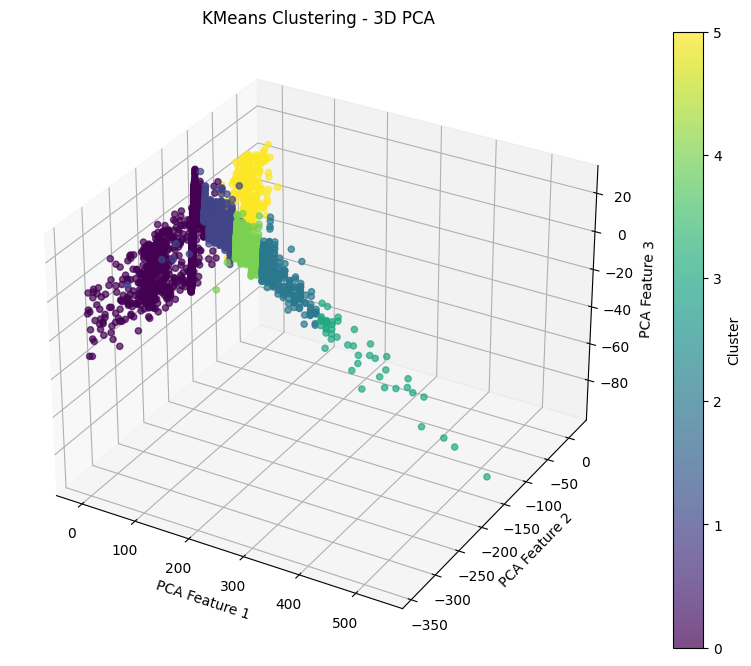

In [76]:
#Kmeans
KMeans_Elbow = KMeans(k=6, seed=1)
KMeans_Elbow = KMeans_Elbow.fit(df_assembled)

df_clustered = KMeans_Elbow.transform(df_assembled)

df_clustered.show(5)
df_clustered.groupBy("prediction").count().show()

from pyspark.ml.feature import PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(k=3, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_clustered)
df_pca = pca_model.transform(df_clustered)

df_pandas = df_pca.select("pca_features", "prediction").toPandas()
df_pandas["pca_feature_1"] = df_pandas["pca_features"].apply(lambda x: x[0])
df_pandas["pca_feature_2"] = df_pandas["pca_features"].apply(lambda x: x[1])
df_pandas["pca_feature_3"] = df_pandas["pca_features"].apply(lambda x: x[2])

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_pandas["pca_feature_1"], df_pandas["pca_feature_2"], df_pandas["pca_feature_3"], c=df_pandas["prediction"], cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label='Cluster')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_zlabel('PCA Feature 3')
ax.set_title('KMeans Clustering - 3D PCA')
plt.show()


+--------+------+----+------------------+-----------------+-----------------+------------------+--------+--------+--------------------+--------------------+----------+
|avg_temp|precip|snow|          wind_dir|       wind_speed|       wind_power|      air_pressure|max_temp|min_temp|            features|         probability|prediction|
+--------+------+----+------------------+-----------------+-----------------+------------------+--------+--------+--------------------+--------------------+----------+
|     4.0|  17.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|     5.5|     0.5|[4.0,17.0,0.0,156...|[6.67252002313771...|         1|
|    18.0|   0.0| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|    24.4|    11.1|[18.0,0.0,0.0,156...|[1.85789775976199...|         1|
|     1.5|   0.1| 0.0|156.79842342342343|7.330333333333331|27.49700000000003|1017.9635555555559|     4.1|     0.3|[1.5,0.1,0.0,156....|[1.34827970361786...|    

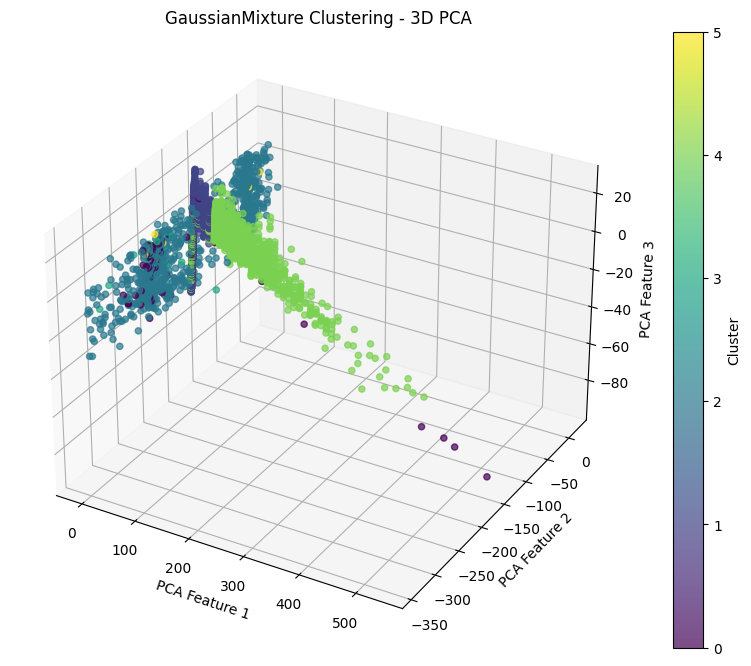

In [81]:
#GaussianMixture
from pyspark.ml.clustering import GaussianMixture
GaussianMixture = GaussianMixture(k=6, seed=1)
GaussianMixture = GaussianMixture.fit(df_assembled)

df_clustered_GaussianMixture = GaussianMixture.transform(df_assembled)

df_clustered_GaussianMixture.show(5)
df_clustered_GaussianMixture.groupBy("prediction").count().show()

pca = PCA(k=3, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(df_clustered_GaussianMixture)
df_pca = pca_model.transform(df_clustered_GaussianMixture)

# Chuyển dữ liệu PCA sang Pandas DataFrame
df_pandas = df_pca.select("pca_features", "prediction").toPandas()
df_pandas["pca_feature_1"] = df_pandas["pca_features"].apply(lambda x: x[0])
df_pandas["pca_feature_2"] = df_pandas["pca_features"].apply(lambda x: x[1])
df_pandas["pca_feature_3"] = df_pandas["pca_features"].apply(lambda x: x[2])

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_pandas["pca_feature_1"], df_pandas["pca_feature_2"], df_pandas["pca_feature_3"], c=df_pandas["prediction"], cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label='Cluster')
ax.set_xlabel('PCA Feature 1')
ax.set_ylabel('PCA Feature 2')
ax.set_zlabel('PCA Feature 3')
ax.set_title('GaussianMixture Clustering - 3D PCA')
plt.show()


In [68]:
#Lưu file csv đã phân cụm
from pyspark.sql import SparkSession

kmeans = df_clustered.toPandas()
GaussianMixture = df_clustered_GaussianMixture.toPandas()

kmeans.to_csv('kmeans_clustered.csv', index=False)
GaussianMixture.to_csv('GaussianMixture_clustered.csv', index=False)

print("Dữ liệu đã được lưu thành công vào")


Dữ liệu đã được lưu thành công vào
